<a href="https://colab.research.google.com/github/cskids/supervised-ml/blob/main/C1_W1_Lab05_Gradient_Descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
"""
lab_utils_common
   contains common routines and variable definitions
   used by all the labs in this week.
   by contrast, specific, large plotting routines will be in separate files
   and are generally imported into the week where they are used.
   those files will import this file
"""
import copy
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from ipywidgets import Output

np.set_printoptions(precision=2)

dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0')
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'
dlcolors = [dlblue, dlorange, dldarkred, dlmagenta, dlpurple]
# plt.style.use('./deeplearning.mplstyle')


def compute_cost(x, y, w, b): 
    """
    Computes the cost function for linear regression.
    
    Args:
      x (ndarray (m,)): Data, m examples 
      y (ndarray (m,)): target values
      w,b (scalar)    : model parameters  
    
    Returns
        total_cost (float): The cost of using w,b as the parameters for linear regression
               to fit the data points in x and y
    """
    # number of training examples
    m = x.shape[0] 
    
    cost_sum = 0 
    for i in range(m): 
        f_wb = w * x[i] + b   
        cost = (f_wb - y[i]) ** 2  
        cost_sum = cost_sum + cost  
    total_cost = (1 / (2 * m)) * cost_sum  

    return total_cost





def sigmoid(z):
    """
    Compute the sigmoid of z
    Parameters
    ----------
    z : array_like
        A scalar or numpy array of any size.
    Returns
    -------
     g : array_like
         sigmoid(z)
    """
    z = np.clip( z, -500, 500 )           # protect against overflow
    g = 1.0/(1.0+np.exp(-z))

    return g

##########################################################
# Regression Routines
##########################################################

def predict_logistic(X, w, b):
    """ performs prediction """
    return sigmoid(X @ w + b)

def predict_linear(X, w, b):
    """ performs prediction """
    return X @ w + b

def compute_cost_logistic(X, y, w, b, lambda_=0, safe=False):
    """
    Computes cost using logistic loss, non-matrix version
    Args:
      X (ndarray): Shape (m,n)  matrix of examples with n features
      y (ndarray): Shape (m,)   target values
      w (ndarray): Shape (n,)   parameters for prediction
      b (scalar):               parameter  for prediction
      lambda_ : (scalar, float) Controls amount of regularization, 0 = no regularization
      safe : (boolean)          True-selects under/overflow safe algorithm
    Returns:
      cost (scalar): cost
    """

    m,n = X.shape
    cost = 0.0
    for i in range(m):
        z_i    = np.dot(X[i],w) + b                                             #(n,)(n,) or (n,) ()
        if safe:  #avoids overflows
            cost += -(y[i] * z_i ) + log_1pexp(z_i)
        else:
            f_wb_i = sigmoid(z_i)                                                   #(n,)
            cost  += -y[i] * np.log(f_wb_i) - (1 - y[i]) * np.log(1 - f_wb_i)       # scalar
    cost = cost/m

    reg_cost = 0
    if lambda_ != 0:
        for j in range(n):
            reg_cost += (w[j]**2)                                               # scalar
        reg_cost = (lambda_/(2*m))*reg_cost

    return cost + reg_cost


def log_1pexp(x, maximum=20):
    ''' approximate log(1+exp^x)
        https://stats.stackexchange.com/questions/475589/numerical-computation-of-cross-entropy-in-practice
    Args:
    x   : (ndarray Shape (n,1) or (n,)  input
    out : (ndarray Shape matches x      output ~= np.log(1+exp(x))
    '''

    out  = np.zeros_like(x,dtype=float)
    i    = x <= maximum
    ni   = np.logical_not(i)

    out[i]  = np.log(1 + np.exp(x[i]))
    out[ni] = x[ni]
    return out


def compute_cost_matrix(X, y, w, b, logistic=False, lambda_=0, safe=True):
    """
    Computes the cost using  using matrices
    Args:
      X : (ndarray, Shape (m,n))          matrix of examples
      y : (ndarray  Shape (m,) or (m,1))  target value of each example
      w : (ndarray  Shape (n,) or (n,1))  Values of parameter(s) of the model
      b : (scalar )                       Values of parameter of the model
      verbose : (Boolean) If true, print out intermediate value f_wb
    Returns:
      total_cost: (scalar)                cost
    """
    m = X.shape[0]
    y = y.reshape(-1,1)             # ensure 2D
    w = w.reshape(-1,1)             # ensure 2D
    if logistic:
        if safe:  #safe from overflow
            z = X @ w + b                                                           #(m,n)(n,1)=(m,1)
            cost = -(y * z) + log_1pexp(z)
            cost = np.sum(cost)/m                                                   # (scalar)
        else:
            f    = sigmoid(X @ w + b)                                               # (m,n)(n,1) = (m,1)
            cost = (1/m)*(np.dot(-y.T, np.log(f)) - np.dot((1-y).T, np.log(1-f)))   # (1,m)(m,1) = (1,1)
            cost = cost[0,0]                                                        # scalar
    else:
        f    = X @ w + b                                                        # (m,n)(n,1) = (m,1)
        cost = (1/(2*m)) * np.sum((f - y)**2)                                   # scalar

    reg_cost = (lambda_/(2*m)) * np.sum(w**2)                                   # scalar

    total_cost = cost + reg_cost                                                # scalar

    return total_cost                                                           # scalar

def compute_gradient_matrix(X, y, w, b, logistic=False, lambda_=0):
    """
    Computes the gradient using matrices
    Args:
      X : (ndarray, Shape (m,n))          matrix of examples
      y : (ndarray  Shape (m,) or (m,1))  target value of each example
      w : (ndarray  Shape (n,) or (n,1))  Values of parameters of the model
      b : (scalar )                       Values of parameter of the model
      logistic: (boolean)                 linear if false, logistic if true
      lambda_:  (float)                   applies regularization if non-zero
    Returns
      dj_dw: (array_like Shape (n,1))     The gradient of the cost w.r.t. the parameters w
      dj_db: (scalar)                     The gradient of the cost w.r.t. the parameter b
    """
    m = X.shape[0]
    y = y.reshape(-1,1)             # ensure 2D
    w = w.reshape(-1,1)             # ensure 2D

    f_wb  = sigmoid( X @ w + b ) if logistic else  X @ w + b      # (m,n)(n,1) = (m,1)
    err   = f_wb - y                                              # (m,1)
    dj_dw = (1/m) * (X.T @ err)                                   # (n,m)(m,1) = (n,1)
    dj_db = (1/m) * np.sum(err)                                   # scalar

    dj_dw += (lambda_/m) * w        # regularize                  # (n,1)

    return dj_db, dj_dw                                           # scalar, (n,1)

def gradient_descent(X, y, w_in, b_in, alpha, num_iters, logistic=False, lambda_=0, verbose=True):
    """
    Performs batch gradient descent to learn theta. Updates theta by taking
    num_iters gradient steps with learning rate alpha
    Args:
      X (ndarray):    Shape (m,n)         matrix of examples
      y (ndarray):    Shape (m,) or (m,1) target value of each example
      w_in (ndarray): Shape (n,) or (n,1) Initial values of parameters of the model
      b_in (scalar):                      Initial value of parameter of the model
      logistic: (boolean)                 linear if false, logistic if true
      lambda_:  (float)                   applies regularization if non-zero
      alpha (float):                      Learning rate
      num_iters (int):                    number of iterations to run gradient descent
    Returns:
      w (ndarray): Shape (n,) or (n,1)    Updated values of parameters; matches incoming shape
      b (scalar):                         Updated value of parameter
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    w = w.reshape(-1,1)      #prep for matrix operations
    y = y.reshape(-1,1)

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = compute_gradient_matrix(X, y, w, b, logistic, lambda_)

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            J_history.append( compute_cost_matrix(X, y, w, b, logistic, lambda_) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            if verbose: print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")

    return w.reshape(w_in.shape), b, J_history  #return final w,b and J history for graphing

def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column
    Args:
      X (ndarray): Shape (m,n) input data, m examples, n features
    Returns:
      X_norm (ndarray): Shape (m,n)  input normalized by column
      mu (ndarray):     Shape (n,)   mean of each feature
      sigma (ndarray):  Shape (n,)   standard deviation of each feature
    """
    # find the mean of each column/feature
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

#check our work
#from sklearn.preprocessing import scale
#scale(X_orig, axis=0, with_mean=True, with_std=True, copy=True)

######################################################
# Common Plotting Routines
######################################################


def plot_data(X, y, ax, pos_label="y=1", neg_label="y=0", s=80, loc='best' ):
    """ plots logistic data with two axis """
    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == 0
    pos = pos.reshape(-1,)  #work with 1D or 1D y vectors
    neg = neg.reshape(-1,)

    # Plot examples
    ax.scatter(X[pos, 0], X[pos, 1], marker='x', s=s, c = 'red', label=pos_label)
    ax.scatter(X[neg, 0], X[neg, 1], marker='o', s=s, label=neg_label, facecolors='none', edgecolors=dlblue, lw=3)
    ax.legend(loc=loc)

    ax.figure.canvas.toolbar_visible = False
    ax.figure.canvas.header_visible = False
    ax.figure.canvas.footer_visible = False

def plt_tumor_data(x, y, ax):
    """ plots tumor data on one axis """
    pos = y == 1
    neg = y == 0

    ax.scatter(x[pos], y[pos], marker='x', s=80, c = 'red', label="malignant")
    ax.scatter(x[neg], y[neg], marker='o', s=100, label="benign", facecolors='none', edgecolors=dlblue,lw=3)
    ax.set_ylim(-0.175,1.1)
    ax.set_ylabel('y')
    ax.set_xlabel('Tumor Size')
    ax.set_title("Logistic Regression on Categorical Data")

    ax.figure.canvas.toolbar_visible = False
    ax.figure.canvas.header_visible = False
    ax.figure.canvas.footer_visible = False

# Draws a threshold at 0.5
def draw_vthresh(ax,x):
    """ draws a threshold """
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    ax.fill_between([xlim[0], x], [ylim[1], ylim[1]], alpha=0.2, color=dlblue)
    ax.fill_between([x, xlim[1]], [ylim[1], ylim[1]], alpha=0.2, color=dldarkred)
    ax.annotate("z >= 0", xy= [x,0.5], xycoords='data',
                xytext=[30,5],textcoords='offset points')
    d = FancyArrowPatch(
        posA=(x, 0.5), posB=(x+3, 0.5), color=dldarkred,
        arrowstyle='simple, head_width=5, head_length=10, tail_width=0.0',
    )
    ax.add_artist(d)
    ax.annotate("z < 0", xy= [x,0.5], xycoords='data',
                 xytext=[-50,5],textcoords='offset points', ha='left')
    f = FancyArrowPatch(
        posA=(x, 0.5), posB=(x-3, 0.5), color=dlblue,
        arrowstyle='simple, head_width=5, head_length=10, tail_width=0.0',
    )
    ax.add_artist(f)

In [5]:
""" 
lab_utils_uni.py
    routines used in Course 1, Week2, labs1-3 dealing with single variables (univariate)
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from ipywidgets import interact
# from lab_utils_common import compute_cost
# from lab_utils_common import dlblue, dlorange, dldarkred, dlmagenta, dlpurple, dlcolors

# plt.style.use('./deeplearning.mplstyle')
n_bin = 5
dlcm = LinearSegmentedColormap.from_list(
        'dl_map', dlcolors, N=n_bin)

##########################################################
# Plotting Routines
##########################################################

def plt_house_x(X, y,f_wb=None, ax=None):
    ''' plot house with aXis '''
    if not ax:
        fig, ax = plt.subplots(1,1)
    ax.scatter(X, y, marker='x', c='r', label="Actual Value")

    ax.set_title("Housing Prices")
    ax.set_ylabel('Price (in 1000s of dollars)')
    ax.set_xlabel(f'Size (1000 sqft)')
    if f_wb is not None:
        ax.plot(X, f_wb,  c=dlblue, label="Our Prediction")
    ax.legend()


def mk_cost_lines(x,y,w,b, ax):
    ''' makes vertical cost lines'''
    cstr = "cost = (1/m)*("
    ctot = 0
    label = 'cost for point'
    addedbreak = False
    for p in zip(x,y):
        f_wb_p = w*p[0]+b
        c_p = ((f_wb_p - p[1])**2)/2
        c_p_txt = c_p
        ax.vlines(p[0], p[1],f_wb_p, lw=3, color=dlpurple, ls='dotted', label=label)
        label='' #just one
        cxy = [p[0], p[1] + (f_wb_p-p[1])/2]
        ax.annotate(f'{c_p_txt:0.0f}', xy=cxy, xycoords='data',color=dlpurple,
            xytext=(5, 0), textcoords='offset points')
        cstr += f"{c_p_txt:0.0f} +"
        if len(cstr) > 38 and addedbreak is False:
            cstr += "\n"
            addedbreak = True
        ctot += c_p
    ctot = ctot/(len(x))
    cstr = cstr[:-1] + f") = {ctot:0.0f}"
    ax.text(0.15,0.02,cstr, transform=ax.transAxes, color=dlpurple)

##########
# Cost lab
##########


def plt_intuition(x_train, y_train):

    w_range = np.array([200-200,200+200])
    tmp_b = 100

    w_array = np.arange(*w_range, 5)
    cost = np.zeros_like(w_array)
    for i in range(len(w_array)):
        tmp_w = w_array[i]
        cost[i] = compute_cost(x_train, y_train, tmp_w, tmp_b)

    @interact(w=(*w_range,10),continuous_update=False)
    def func( w=150):
        f_wb = np.dot(x_train, w) + tmp_b

        fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(8,4))
        fig.canvas.toolbar_position = 'bottom'

        mk_cost_lines(x_train, y_train, w, tmp_b, ax[0])
        plt_house_x(x_train, y_train, f_wb=f_wb, ax=ax[0])

        ax[1].plot(w_array, cost)
        cur_cost = compute_cost(x_train, y_train, w, tmp_b)
        ax[1].scatter(w,cur_cost, s=100, color=dldarkred, zorder= 10, label= f"cost at w={w}")
        ax[1].hlines(cur_cost, ax[1].get_xlim()[0],w, lw=4, color=dlpurple, ls='dotted')
        ax[1].vlines(w, ax[1].get_ylim()[0],cur_cost, lw=4, color=dlpurple, ls='dotted')
        ax[1].set_title("Cost vs. w, (b fixed at 100)")
        ax[1].set_ylabel('Cost')
        ax[1].set_xlabel('w')
        ax[1].legend(loc='upper center')
        fig.suptitle(f"Minimize Cost: Current Cost = {cur_cost:0.0f}", fontsize=12)
        plt.show()

# this is the 2D cost curve with interactive slider
def plt_stationary(x_train, y_train):
    # setup figure
    fig = plt.figure( figsize=(9,8))
    #fig = plt.figure(constrained_layout=True,  figsize=(12,10))
    fig.set_facecolor('#ffffff') #white
    fig.canvas.toolbar_position = 'top'
    #gs = GridSpec(2, 2, figure=fig, wspace = 0.01)
    gs = GridSpec(2, 2, figure=fig)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, :],  projection='3d')
    ax = np.array([ax0,ax1,ax2])

    #setup useful ranges and common linspaces
    w_range = np.array([200-300.,200+300])
    b_range = np.array([50-300., 50+300])
    b_space  = np.linspace(*b_range, 100)
    w_space  = np.linspace(*w_range, 100)

    # get cost for w,b ranges for contour and 3D
    tmp_b,tmp_w = np.meshgrid(b_space,w_space)
    z=np.zeros_like(tmp_b)
    for i in range(tmp_w.shape[0]):
        for j in range(tmp_w.shape[1]):
            z[i,j] = compute_cost(x_train, y_train, tmp_w[i][j], tmp_b[i][j] )
            if z[i,j] == 0: z[i,j] = 1e-6

    w0=200;b=-100    #initial point
    ### plot model w cost ###
    f_wb = np.dot(x_train,w0) + b
    mk_cost_lines(x_train,y_train,w0,b,ax[0])
    plt_house_x(x_train, y_train, f_wb=f_wb, ax=ax[0])

    ### plot contour ###
    CS = ax[1].contour(tmp_w, tmp_b, np.log(z),levels=12, linewidths=2, alpha=0.7,colors=dlcolors)
    ax[1].set_title('Cost(w,b)')
    ax[1].set_xlabel('w', fontsize=10)
    ax[1].set_ylabel('b', fontsize=10)
    ax[1].set_xlim(w_range) ; ax[1].set_ylim(b_range)
    cscat  = ax[1].scatter(w0,b, s=100, color=dlblue, zorder= 10, label="cost with \ncurrent w,b")
    chline = ax[1].hlines(b, ax[1].get_xlim()[0],w0, lw=4, color=dlpurple, ls='dotted')
    cvline = ax[1].vlines(w0, ax[1].get_ylim()[0],b, lw=4, color=dlpurple, ls='dotted')
    ax[1].text(0.5,0.95,"Click to choose w,b",  bbox=dict(facecolor='white', ec = 'black'), fontsize = 10,
                transform=ax[1].transAxes, verticalalignment = 'center', horizontalalignment= 'center')

    #Surface plot of the cost function J(w,b)
    ax[2].plot_surface(tmp_w, tmp_b, z,  cmap = dlcm, alpha=0.3, antialiased=True)
    ax[2].plot_wireframe(tmp_w, tmp_b, z, color='k', alpha=0.1)
    plt.xlabel("$w$")
    plt.ylabel("$b$")
    ax[2].zaxis.set_rotate_label(False)
    ax[2].xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax[2].yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax[2].zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax[2].set_zlabel("J(w, b)\n\n", rotation=90)
    plt.title("Cost(w,b) \n [You can rotate this figure]", size=12)
    ax[2].view_init(30, -120)

    return fig,ax, [cscat, chline, cvline]


#https://matplotlib.org/stable/users/event_handling.html
class plt_update_onclick:
    def __init__(self, fig, ax, x_train,y_train, dyn_items):
        self.fig = fig
        self.ax = ax
        self.x_train = x_train
        self.y_train = y_train
        self.dyn_items = dyn_items
        self.cid = fig.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event):
        if event.inaxes == self.ax[1]:
            ws = event.xdata
            bs = event.ydata
            cst = compute_cost(self.x_train, self.y_train, ws, bs)

            # clear and redraw line plot
            self.ax[0].clear()
            f_wb = np.dot(self.x_train,ws) + bs
            mk_cost_lines(self.x_train,self.y_train,ws,bs,self.ax[0])
            plt_house_x(self.x_train, self.y_train, f_wb=f_wb, ax=self.ax[0])

            # remove lines and re-add on countour plot and 3d plot
            for artist in self.dyn_items:
                artist.remove()

            a = self.ax[1].scatter(ws,bs, s=100, color=dlblue, zorder= 10, label="cost with \ncurrent w,b")
            b = self.ax[1].hlines(bs, self.ax[1].get_xlim()[0],ws, lw=4, color=dlpurple, ls='dotted')
            c = self.ax[1].vlines(ws, self.ax[1].get_ylim()[0],bs, lw=4, color=dlpurple, ls='dotted')
            d = self.ax[1].annotate(f"Cost: {cst:.0f}", xy= (ws, bs), xytext = (4,4), textcoords = 'offset points',
                               bbox=dict(facecolor='white'), size = 10)

            #Add point in 3D surface plot
            e = self.ax[2].scatter3D(ws, bs,cst , marker='X', s=100)

            self.dyn_items = [a,b,c,d,e]
            self.fig.canvas.draw()


def soup_bowl():
    """ Create figure and plot with a 3D projection"""
    fig = plt.figure(figsize=(8,8))

    #Plot configuration
    ax = fig.add_subplot(111, projection='3d')
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_rotate_label(False)
    ax.view_init(45, -120)

    #Useful linearspaces to give values to the parameters w and b
    w = np.linspace(-20, 20, 100)
    b = np.linspace(-20, 20, 100)

    #Get the z value for a bowl-shaped cost function
    z=np.zeros((len(w), len(b)))
    j=0
    for x in w:
        i=0
        for y in b:
            z[i,j] = x**2 + y**2
            i+=1
        j+=1

    #Meshgrid used for plotting 3D functions
    W, B = np.meshgrid(w, b)

    #Create the 3D surface plot of the bowl-shaped cost function
    ax.plot_surface(W, B, z, cmap = "Spectral_r", alpha=0.7, antialiased=False)
    ax.plot_wireframe(W, B, z, color='k', alpha=0.1)
    ax.set_xlabel("$w$")
    ax.set_ylabel("$b$")
    ax.set_zlabel("$J(w,b)$", rotation=90)
    ax.set_title("$J(w,b)$\n [You can rotate this figure]", size=15)

    plt.show()

def inbounds(a,b,xlim,ylim):
    xlow,xhigh = xlim
    ylow,yhigh = ylim
    ax, ay = a
    bx, by = b
    if (ax > xlow and ax < xhigh) and (bx > xlow and bx < xhigh) \
        and (ay > ylow and ay < yhigh) and (by > ylow and by < yhigh):
        return True
    return False

def plt_contour_wgrad(x, y, hist, ax, w_range=[-100, 500, 5], b_range=[-500, 500, 5],
                contours = [0.1,50,1000,5000,10000,25000,50000],
                      resolution=5, w_final=200, b_final=100,step=10 ):
    b0,w0 = np.meshgrid(np.arange(*b_range),np.arange(*w_range))
    z=np.zeros_like(b0)
    for i in range(w0.shape[0]):
        for j in range(w0.shape[1]):
            z[i][j] = compute_cost(x, y, w0[i][j], b0[i][j] )

    CS = ax.contour(w0, b0, z, contours, linewidths=2,
                   colors=[dlblue, dlorange, dldarkred, dlmagenta, dlpurple])
    ax.clabel(CS, inline=1, fmt='%1.0f', fontsize=10)
    ax.set_xlabel("w");  ax.set_ylabel("b")
    ax.set_title('Contour plot of cost J(w,b), vs b,w with path of gradient descent')
    w = w_final; b=b_final
    ax.hlines(b, ax.get_xlim()[0],w, lw=2, color=dlpurple, ls='dotted')
    ax.vlines(w, ax.get_ylim()[0],b, lw=2, color=dlpurple, ls='dotted')

    base = hist[0]
    for point in hist[0::step]:
        edist = np.sqrt((base[0] - point[0])**2 + (base[1] - point[1])**2)
        if(edist > resolution or point==hist[-1]):
            if inbounds(point,base, ax.get_xlim(),ax.get_ylim()):
                plt.annotate('', xy=point, xytext=base,xycoords='data',
                         arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 3},
                         va='center', ha='center')
            base=point
    return


def plt_divergence(p_hist, J_hist, x_train,y_train):

    x=np.zeros(len(p_hist))
    y=np.zeros(len(p_hist))
    v=np.zeros(len(p_hist))
    for i in range(len(p_hist)):
        x[i] = p_hist[i][0]
        y[i] = p_hist[i][1]
        v[i] = J_hist[i]

    fig = plt.figure(figsize=(12,5))
    plt.subplots_adjust( wspace=0 )
    gs = fig.add_gridspec(1, 5)
    fig.suptitle(f"Cost escalates when learning rate is too large")
    #===============
    #  First subplot
    #===============
    ax = fig.add_subplot(gs[:2], )

    # Print w vs cost to see minimum
    fix_b = 100
    w_array = np.arange(-70000, 70000, 1000)
    cost = np.zeros_like(w_array)

    for i in range(len(w_array)):
        tmp_w = w_array[i]
        cost[i] = compute_cost(x_train, y_train, tmp_w, fix_b)

    ax.plot(w_array, cost)
    ax.plot(x,v, c=dlmagenta)
    ax.set_title("Cost vs w, b set to 100")
    ax.set_ylabel('Cost')
    ax.set_xlabel('w')
    ax.xaxis.set_major_locator(MaxNLocator(2))

    #===============
    # Second Subplot
    #===============

    tmp_b,tmp_w = np.meshgrid(np.arange(-35000, 35000, 500),np.arange(-70000, 70000, 500))
    z=np.zeros_like(tmp_b)
    for i in range(tmp_w.shape[0]):
        for j in range(tmp_w.shape[1]):
            z[i][j] = compute_cost(x_train, y_train, tmp_w[i][j], tmp_b[i][j] )

    ax = fig.add_subplot(gs[2:], projection='3d')
    ax.plot_surface(tmp_w, tmp_b, z,  alpha=0.3, color=dlblue)
    ax.xaxis.set_major_locator(MaxNLocator(2))
    ax.yaxis.set_major_locator(MaxNLocator(2))

    ax.set_xlabel('w', fontsize=16)
    ax.set_ylabel('b', fontsize=16)
    ax.set_zlabel('\ncost', fontsize=16)
    plt.title('Cost vs (b, w)')
    # Customize the view angle
    ax.view_init(elev=20., azim=-65)
    ax.plot(x, y, v,c=dlmagenta)

    return

# draw derivative line
# y = m*(x - x1) + y1
def add_line(dj_dx, x1, y1, d, ax):
    x = np.linspace(x1-d, x1+d,50)
    y = dj_dx*(x - x1) + y1
    ax.scatter(x1, y1, color=dlblue, s=50)
    ax.plot(x, y, '--', c=dldarkred,zorder=10, linewidth = 1)
    xoff = 30 if x1 == 200 else 10
    ax.annotate(r"$\frac{\partial J}{\partial w}$ =%d" % dj_dx, fontsize=14,
                xy=(x1, y1), xycoords='data',
            xytext=(xoff, 10), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"),
            horizontalalignment='left', verticalalignment='top')

def plt_gradients(x_train,y_train, f_compute_cost, f_compute_gradient):
    #===============
    #  First subplot
    #===============
    fig,ax = plt.subplots(1,2,figsize=(12,4))

    # Print w vs cost to see minimum
    fix_b = 100
    w_array = np.linspace(-100, 500, 50)
    w_array = np.linspace(0, 400, 50)
    cost = np.zeros_like(w_array)

    for i in range(len(w_array)):
        tmp_w = w_array[i]
        cost[i] = f_compute_cost(x_train, y_train, tmp_w, fix_b)
    ax[0].plot(w_array, cost,linewidth=1)
    ax[0].set_title("Cost vs w, with gradient; b set to 100")
    ax[0].set_ylabel('Cost')
    ax[0].set_xlabel('w')

    # plot lines for fixed b=100
    for tmp_w in [100,200,300]:
        fix_b = 100
        dj_dw,dj_db = f_compute_gradient(x_train, y_train, tmp_w, fix_b )
        j = f_compute_cost(x_train, y_train, tmp_w, fix_b)
        add_line(dj_dw, tmp_w, j, 30, ax[0])

    #===============
    # Second Subplot
    #===============

    tmp_b,tmp_w = np.meshgrid(np.linspace(-200, 200, 10), np.linspace(-100, 600, 10))
    U = np.zeros_like(tmp_w)
    V = np.zeros_like(tmp_b)
    for i in range(tmp_w.shape[0]):
        for j in range(tmp_w.shape[1]):
            U[i][j], V[i][j] = f_compute_gradient(x_train, y_train, tmp_w[i][j], tmp_b[i][j] )
    X = tmp_w
    Y = tmp_b
    n=-2
    color_array = np.sqrt(((V-n)/2)**2 + ((U-n)/2)**2)

    ax[1].set_title('Gradient shown in quiver plot')
    Q = ax[1].quiver(X, Y, U, V, color_array, units='width', )
    ax[1].quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E',coordinates='figure')
    ax[1].set_xlabel("w"); ax[1].set_ylabel("b")

# Optional Lab: Gradient Descent for Linear Regression
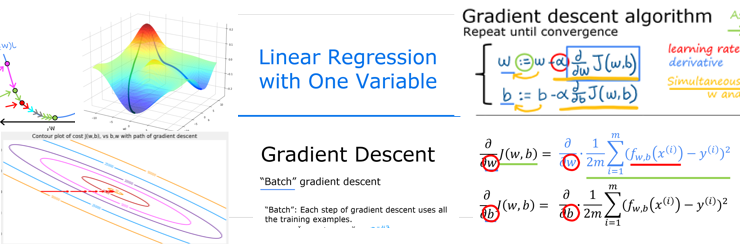

## Goals
In this lab, you will:
- automate the process of optimizing $w$ and $b$ using gradient descent.

## Tools
In this lab, we will make use of: 
- NumPy, a popular library for scientific computing
- Matplotlib, a popular library for plotting data
- plotting routines in the lab_utils.py file in the local directory

In [3]:
import math, copy
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('./deeplearning.mplstyle')
# from lab_utils_uni import plt_house_x, plt_contour_wgrad, plt_divergence, plt_gradients

<a name="toc_40291_2"></a>
# Problem Statement

Let's use the same two data points as before - a house with 1000 square feet sold for \\$300,000 and a house with 2000 square feet sold for \\$500,000.

| Size (1000 sqft)     | Price (1000s of dollars) |
| ----------------| ------------------------ |
| 1               | 300                      |
| 2               | 500                      |


In [6]:
# Load our data set
x_train = np.array([1.0, 2.0])   #features
y_train = np.array([300.0, 500.0])   #target value

<a name="toc_40291_2.0.1"></a>
### Compute_Cost
This was developed in the last lab. We'll need it again here.

In [7]:
#Function to calculate the cost
def compute_cost(x, y, w, b):
   
    m = x.shape[0] 
    cost = 0
    
    for i in range(m):
        f_wb = w * x[i] + b
        cost = cost + (f_wb - y[i])**2
    total_cost = 1 / (2 * m) * cost

    return total_cost

<a name="toc_40291_2.1"></a>
## Gradient descent summary
So far in this course, you have developed a linear model that predicts $f_{w,b}(x^{(i)})$:
$$f_{w,b}(x^{(i)}) = wx^{(i)} + b \tag{1}$$
In linear regression, you utilize input training data to fit the parameters $w$,$b$ by minimizing a measure of the error between our predictions $f_{w,b}(x^{(i)})$ and the actual data $y^{(i)}$. The measure is called the $cost$, $J(w,b)$. In training you measure the cost over all of our training samples $x^{(i)},y^{(i)}$
$$J(w,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2\tag{2}$$ 


In lecture, *gradient descent* was described as:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline
\;  w &= w -  \alpha \frac{\partial J(w,b)}{\partial w} \tag{3}  \; \newline 
 b &= b -  \alpha \frac{\partial J(w,b)}{\partial b}  \newline \rbrace
\end{align*}$$
where, parameters $w$, $b$ are updated simultaneously.  
The gradient is defined as:
$$
\begin{align}
\frac{\partial J(w,b)}{\partial w}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} \tag{4}\\
  \frac{\partial J(w,b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \tag{5}\\
\end{align}
$$

Here *simultaniously* means that you calculate the partial derivatives for all the parameters before updating any of the parameters.

<a name="toc_40291_2.2"></a>
## Implement Gradient Descent
You will implement gradient descent algorithm for one feature. You will need three functions. 
- `compute_gradient` implementing equation (4) and (5) above
- `compute_cost` implementing equation (2) above (code from previous lab)
- `gradient_descent`, utilizing compute_gradient and compute_cost

Conventions:
- The naming of python variables containing partial derivatives follows this pattern,$\frac{\partial J(w,b)}{\partial b}$  will be `dj_db`.
- w.r.t is With Respect To, as in partial derivative of $J(wb)$ With Respect To $b$.


<a name="toc_40291_2.3"></a>
### compute_gradient
<a name='ex-01'></a>
`compute_gradient`  implements (4) and (5) above and returns $\frac{\partial J(w,b)}{\partial w}$,$\frac{\partial J(w,b)}{\partial b}$. The embedded comments describe the operations.

In [8]:
def compute_gradient(x, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      x (ndarray (m,)): Data, m examples 
      y (ndarray (m,)): target values
      w,b (scalar)    : model parameters  
    Returns
      dj_dw (scalar): The gradient of the cost w.r.t. the parameters w
      dj_db (scalar): The gradient of the cost w.r.t. the parameter b     
     """
    
    # Number of training examples
    m = x.shape[0]    
    dj_dw = 0
    dj_db = 0
    
    for i in range(m):  
        f_wb = w * x[i] + b 
        dj_dw_i = (f_wb - y[i]) * x[i] 
        dj_db_i = f_wb - y[i] 
        dj_db += dj_db_i
        dj_dw += dj_dw_i 
    dj_dw = dj_dw / m 
    dj_db = dj_db / m 
        
    return dj_dw, dj_db

<br/>

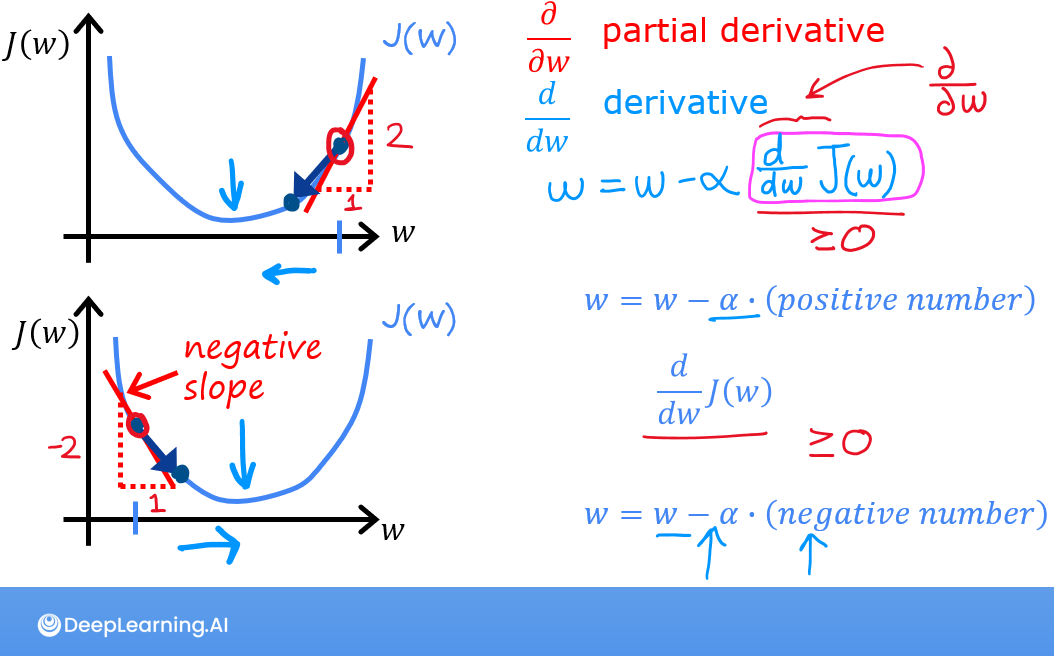 The lectures described how gradient descent utilizes the partial derivative of the cost with respect to a parameter at a point to update that parameter.   
Let's use our `compute_gradient` function to find and plot some partial derivatives of our cost function relative to one of the parameters, $w_0$.


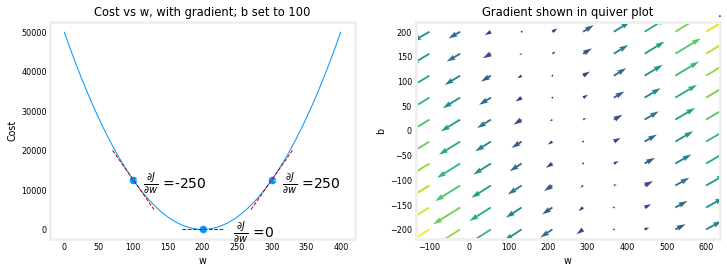

In [ ]:
plt_gradients(x_train,y_train, compute_cost, compute_gradient)
plt.show()

Above, the left plot shows $\frac{\partial J(w,b)}{\partial w}$ or the slope of the cost curve relative to $w$ at three points. On the right side of the plot, the derivative is positive, while on the left it is negative. Due to the 'bowl shape', the derivatives will always lead gradient descent toward the bottom where the gradient is zero.
 
The left plot has fixed $b=100$. Gradient descent will utilize both $\frac{\partial J(w,b)}{\partial w}$ and $\frac{\partial J(w,b)}{\partial b}$ to update parameters. The 'quiver plot' on the right provides a means of viewing the gradient of both parameters. The arrow sizes reflect the magnitude of the gradient at that point. The direction and slope of the arrow reflects the ratio of $\frac{\partial J(w,b)}{\partial w}$ and $\frac{\partial J(w,b)}{\partial b}$ at that point.
Note that the gradient points *away* from the minimum. Review equation (3) above. The scaled gradient is *subtracted* from the current value of $w$ or $b$. This moves the parameter in a direction that will reduce cost.

<a name="toc_40291_2.5"></a>
###  Gradient Descent
Now that gradients can be computed,  gradient descent, described in equation (3) above can be implemented below in `gradient_descent`. The details of the implementation are described in the comments. Below, you will utilize this function to find optimal values of $w$ and $b$ on the training data.

In [9]:
def gradient_descent(x, y, w_in, b_in, alpha, num_iters, cost_function, gradient_function): 
    """
    Performs gradient descent to fit w,b. Updates w,b by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      x (ndarray (m,))  : Data, m examples 
      y (ndarray (m,))  : target values
      w_in,b_in (scalar): initial values of model parameters  
      alpha (float):     Learning rate
      num_iters (int):   number of iterations to run gradient descent
      cost_function:     function to call to produce cost
      gradient_function: function to call to produce gradient
      
    Returns:
      w (scalar): Updated value of parameter after running gradient descent
      b (scalar): Updated value of parameter after running gradient descent
      J_history (List): History of cost values
      p_history (list): History of parameters [w,b] 
      """
    
    w = copy.deepcopy(w_in) # avoid modifying global w_in
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    p_history = []
    b = b_in
    w = w_in
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters using gradient_function
        dj_dw, dj_db = gradient_function(x, y, w , b)     

        # Update Parameters using equation (3) above
        b = b - alpha * dj_db                            
        w = w - alpha * dj_dw                            

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( cost_function(x, y, w , b))
            p_history.append([w,b])
        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0:
            print(f"Iteration {i:4}: Cost {J_history[-1]:0.2e} ",
                  f"dj_dw: {dj_dw: 0.3e}, dj_db: {dj_db: 0.3e}  ",
                  f"w: {w: 0.3e}, b:{b: 0.5e}")
 
    return w, b, J_history, p_history #return w and J,w history for graphing

In [10]:
# initialize parameters
w_init = 0
b_init = 0
# some gradient descent settings
iterations = 10000
tmp_alpha = 1.0e-2
# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent(x_train ,y_train, w_init, b_init, tmp_alpha, 
                                                    iterations, compute_cost, compute_gradient)
print(f"(w,b) found by gradient descent: ({w_final:8.4f},{b_final:8.4f})")

Iteration    0: Cost 7.93e+04  dj_dw: -6.500e+02, dj_db: -4.000e+02   w:  6.500e+00, b: 4.00000e+00
Iteration 1000: Cost 3.41e+00  dj_dw: -3.712e-01, dj_db:  6.007e-01   w:  1.949e+02, b: 1.08228e+02
Iteration 2000: Cost 7.93e-01  dj_dw: -1.789e-01, dj_db:  2.895e-01   w:  1.975e+02, b: 1.03966e+02
Iteration 3000: Cost 1.84e-01  dj_dw: -8.625e-02, dj_db:  1.396e-01   w:  1.988e+02, b: 1.01912e+02
Iteration 4000: Cost 4.28e-02  dj_dw: -4.158e-02, dj_db:  6.727e-02   w:  1.994e+02, b: 1.00922e+02
Iteration 5000: Cost 9.95e-03  dj_dw: -2.004e-02, dj_db:  3.243e-02   w:  1.997e+02, b: 1.00444e+02
Iteration 6000: Cost 2.31e-03  dj_dw: -9.660e-03, dj_db:  1.563e-02   w:  1.999e+02, b: 1.00214e+02
Iteration 7000: Cost 5.37e-04  dj_dw: -4.657e-03, dj_db:  7.535e-03   w:  1.999e+02, b: 1.00103e+02
Iteration 8000: Cost 1.25e-04  dj_dw: -2.245e-03, dj_db:  3.632e-03   w:  2.000e+02, b: 1.00050e+02
Iteration 9000: Cost 2.90e-05  dj_dw: -1.082e-03, dj_db:  1.751e-03   w:  2.000e+02, b: 1.00024e+02


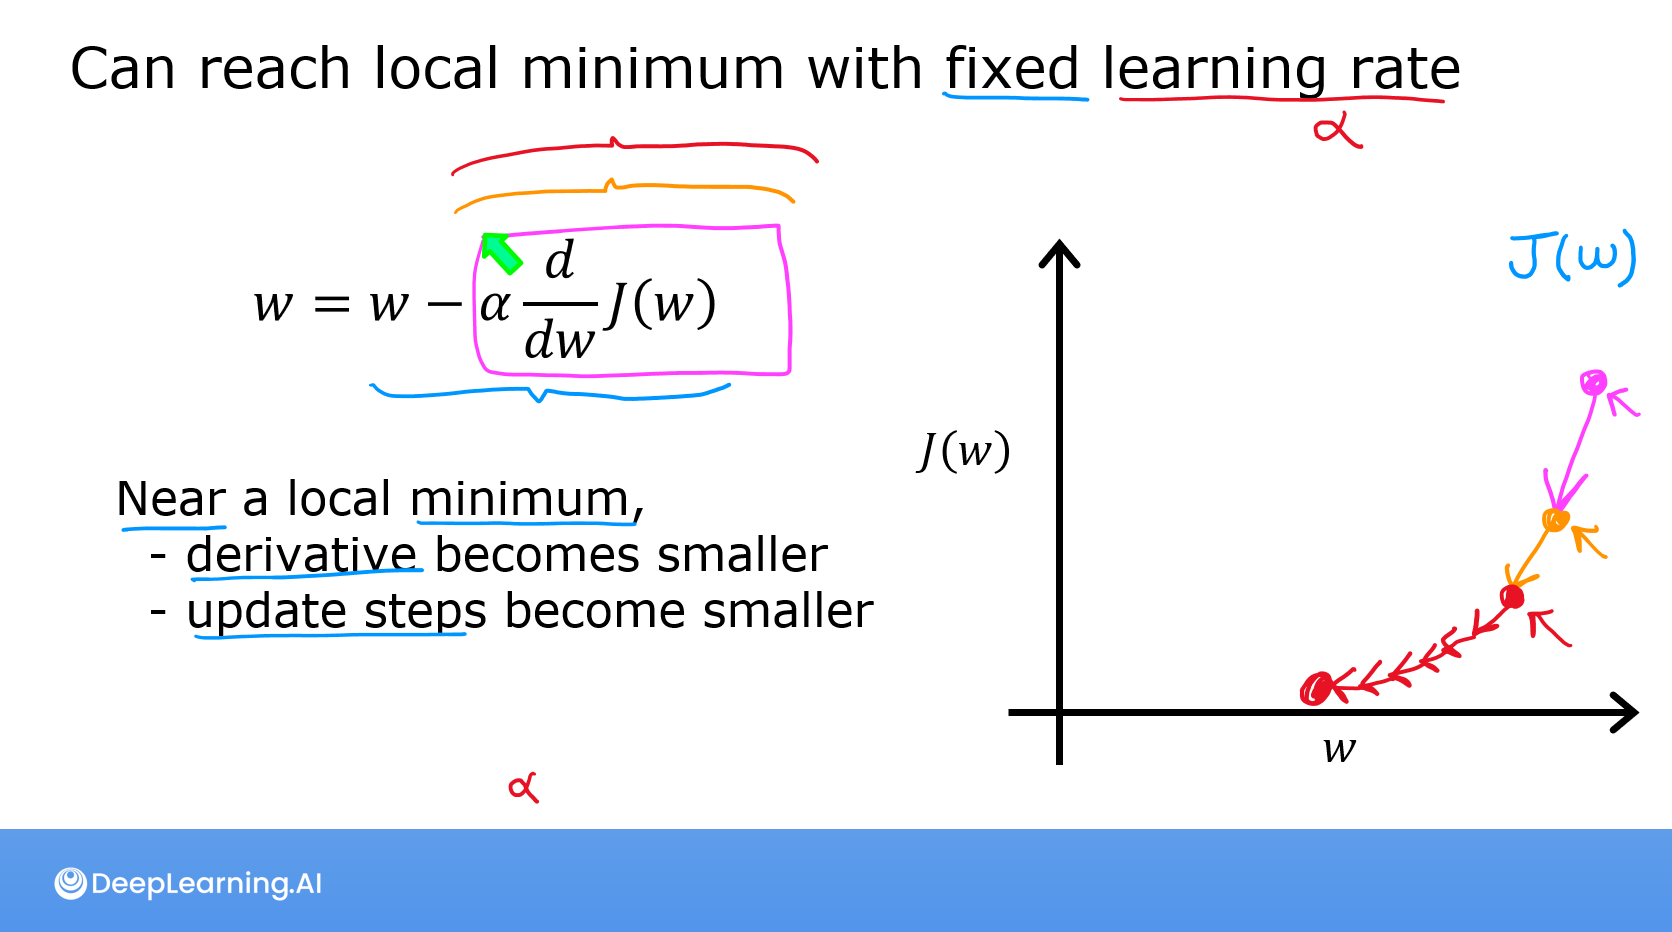
Take a moment and note some characteristics of the gradient descent process printed above.  

- The cost starts large and rapidly declines as described in the slide from the lecture.
- The partial derivatives, `dj_dw`, and `dj_db` also get smaller, rapidly at first and then more slowly. As shown in the diagram from the lecture, as the process nears the 'bottom of the bowl' progress is slower due to the smaller value of the derivative at that point.
- progress slows though the learning rate, alpha, remains fixed

### Cost versus iterations of gradient descent 
A plot of cost versus iterations is a useful measure of progress in gradient descent. Cost should always decrease in successful runs. The change in cost is so rapid initially, it is useful to plot the initial decent on a different scale than the final descent. In the plots below, note the scale of cost on the axes and the iteration step.

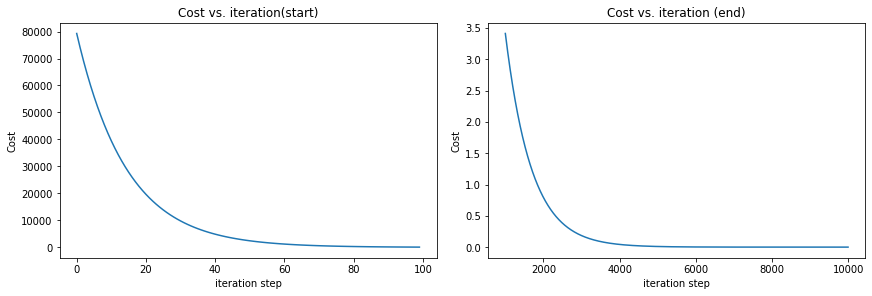

In [11]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))
ax1.plot(J_hist[:100])
ax2.plot(1000 + np.arange(len(J_hist[1000:])), J_hist[1000:])
ax1.set_title("Cost vs. iteration(start)");  ax2.set_title("Cost vs. iteration (end)")
ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')  ;  ax2.set_xlabel('iteration step') 
plt.show()

### Predictions
Now that you have discovered the optimal values for the parameters $w$ and $b$, you can now use the model to predict housing values based on our learned parameters. As expected, the predicted values are nearly the same as the training values for the same housing. Further, the value not in the prediction is in line with the expected value.

In [12]:
print(f"1000 sqft house prediction {w_final*1.0 + b_final:0.1f} Thousand dollars")
print(f"1200 sqft house prediction {w_final*1.2 + b_final:0.1f} Thousand dollars")
print(f"2000 sqft house prediction {w_final*2.0 + b_final:0.1f} Thousand dollars")

1000 sqft house prediction 300.0 Thousand dollars
1200 sqft house prediction 340.0 Thousand dollars
2000 sqft house prediction 500.0 Thousand dollars


<a name="toc_40291_2.6"></a>
## Plotting
You can show the progress of gradient descent during its execution by plotting the cost over iterations on a contour plot of the cost(w,b). 

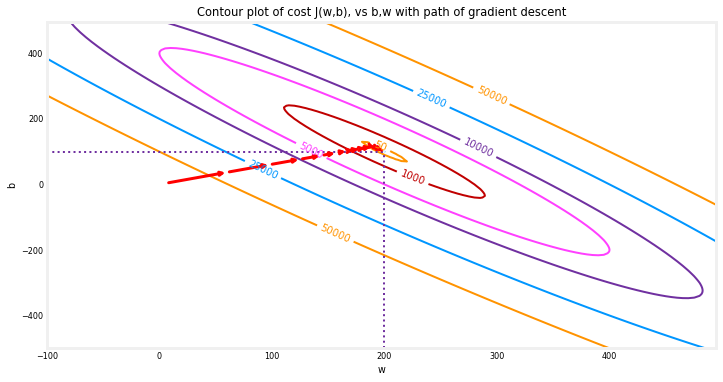

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
plt_contour_wgrad(x_train, y_train, p_hist, ax)

Above, the contour plot shows the $cost(w,b)$ over a range of $w$ and $b$. Cost levels are represented by the rings. Overlayed, using red arrows, is the path of gradient descent. Here are some things to note:
- The path makes steady (monotonic) progress toward its goal.
- initial steps are much larger than the steps near the goal.

**Zooming in**, we can see that final steps of gradient descent. Note the distance between steps shrinks as the gradient approaches zero.

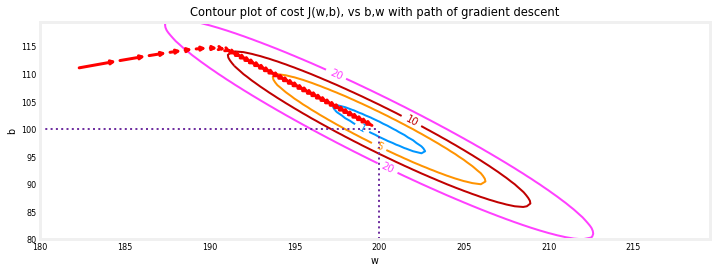

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))
plt_contour_wgrad(x_train, y_train, p_hist, ax, w_range=[180, 220, 0.5], b_range=[80, 120, 0.5],
            contours=[1,5,10,20],resolution=0.5)

<a name="toc_40291_2.7.1"></a>
### Increased Learning Rate

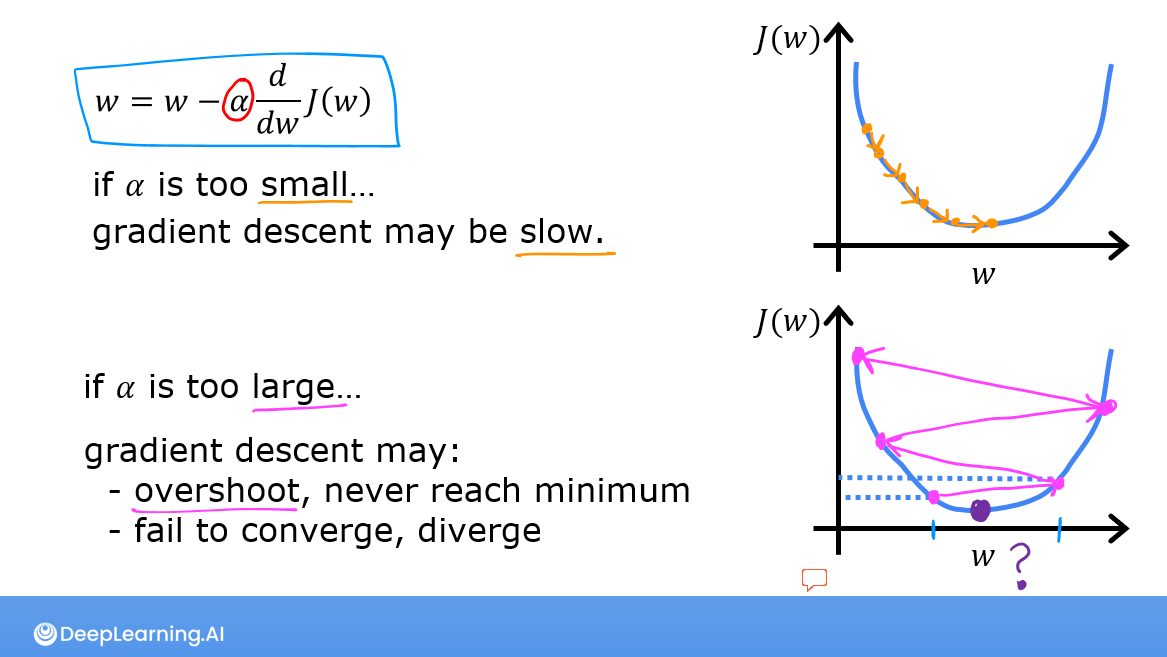
In the lecture, there was a discussion related to the proper value of the learning rate, $\alpha$ in equation(3). The larger $\alpha$ is, the faster gradient descent will converge to a solution. But, if it is too large, gradient descent will diverge. Above you have an example of a solution which converges nicely.

Let's try increasing the value of  $\alpha$ and see what happens:

In [13]:
# initialize parameters
w_init = 0
b_init = 0
# set alpha to a large value
iterations = 10
tmp_alpha = 8.0e-1
# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent(x_train ,y_train, w_init, b_init, tmp_alpha, 
                                                    iterations, compute_cost, compute_gradient)

Iteration    0: Cost 2.58e+05  dj_dw: -6.500e+02, dj_db: -4.000e+02   w:  5.200e+02, b: 3.20000e+02
Iteration    1: Cost 7.82e+05  dj_dw:  1.130e+03, dj_db:  7.000e+02   w: -3.840e+02, b:-2.40000e+02
Iteration    2: Cost 2.37e+06  dj_dw: -1.970e+03, dj_db: -1.216e+03   w:  1.192e+03, b: 7.32800e+02
Iteration    3: Cost 7.19e+06  dj_dw:  3.429e+03, dj_db:  2.121e+03   w: -1.551e+03, b:-9.63840e+02
Iteration    4: Cost 2.18e+07  dj_dw: -5.974e+03, dj_db: -3.691e+03   w:  3.228e+03, b: 1.98886e+03
Iteration    5: Cost 6.62e+07  dj_dw:  1.040e+04, dj_db:  6.431e+03   w: -5.095e+03, b:-3.15579e+03
Iteration    6: Cost 2.01e+08  dj_dw: -1.812e+04, dj_db: -1.120e+04   w:  9.402e+03, b: 5.80237e+03
Iteration    7: Cost 6.09e+08  dj_dw:  3.156e+04, dj_db:  1.950e+04   w: -1.584e+04, b:-9.80139e+03
Iteration    8: Cost 1.85e+09  dj_dw: -5.496e+04, dj_db: -3.397e+04   w:  2.813e+04, b: 1.73730e+04
Iteration    9: Cost 5.60e+09  dj_dw:  9.572e+04, dj_db:  5.916e+04   w: -4.845e+04, b:-2.99567e+04


Above, $w$ and $b$ are bouncing back and forth between positive and negative with the absolute value increasing with each iteration. Further, each iteration $\frac{\partial J(w,b)}{\partial w}$ changes sign and cost is increasing rather than decreasing. This is a clear sign that the *learning rate is too large* and the solution is diverging. 
Let's visualize this with a plot.

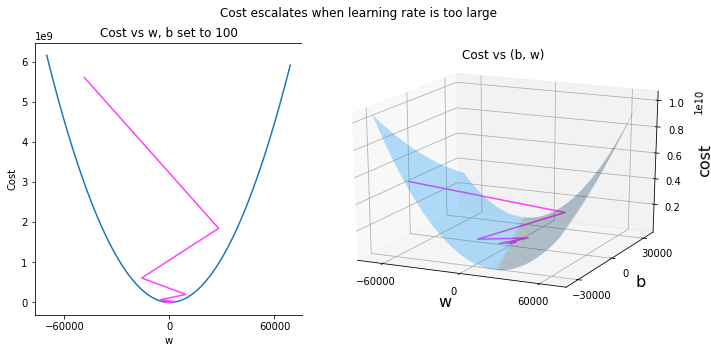

In [14]:
plt_divergence(p_hist, J_hist,x_train, y_train)
plt.show()

Above, the left graph shows $w$'s progression over the first few steps of gradient descent. $w$ oscillates from positive to negative and cost grows rapidly. Gradient Descent is operating on both $w$ and $b$ simultaneously, so one needs the 3-D plot on the right for the complete picture.


## Congratulations!
In this lab you:
- delved into the details of gradient descent for a single variable.
- developed a routine to compute the gradient
- visualized what the gradient is
- completed a gradient descent routine
- utilized gradient descent to find parameters
- examined the impact of sizing the learning rate